## Objective: 

**Predicting BTCUSDT Price Trend With Deep Learinig Model**

In a series of ongoing experiments, I have been exploring the potential of machine learning in forecasting the future trend of BTC prices, with an ultimate goal to harness these predictions as indicators for a trading system. My journey began with basic models, gradually elevating to ensemble techniques, all in pursuit of accurately anticipating BTC price movements.

Initially, my strategy revolved around predicting the MACD for a 2-hour span. However, due to MACD's inherent sensitivity leading to false signals, I pivoted to using fast/slow EMAs to better discern the trend. Despite these adjustments, the predictive capability of the models remained constrained to a mere 1-2 hours into the future.

Building on these findings, this experiment aims to delve deeper. We will be integrating Deep Learning techniques, aiming to expand our forecasting horizon to 3-5 hours ahead, anticipating that such advanced models might offer us a clearer window into future BTC price movements.

**Data source**: 

- Binance
- BTCUSDT hourly prices in JSON.

**Prediction Logic**:
- **+2 (Strong Upward Trend)**: Conditions – EMA 10 > EMA 20 and exhibits an increase from its previous value.
- **+1 (Weak Upward Trend)**: Conditions – EMA 10 > EMA 20, but there's a decrease relative to its prior value.
- **-2 (Strong Downward Trend)**: Conditions – EMA 10 < EMA 20 and further decreases from its preceding value.
- **-1 (Weak Downward Trend)**: Conditions – EMA 10 < EMA 20 but shows an increase when juxtaposed with its preceding value.
- **0 (No Clear Trend)**: Conditions – differt of EMA 10 and EMA 20 between threshold values.

### Target and features

In [22]:
import numpy as np
import pandas as pd
import talib

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

    # change datetime to index
    df.set_index('datetime', inplace=True)
    
    df = remove_outlier(df)
    return df

In [23]:
def get_target_next_ema_diff(df, target_shift = 3):
    
    target_threshold = 0.2
    # oclh
    df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    # diff between ema 10 and 20
    df['ema_10'] = talib.EMA(df['ohlc'], timeperiod=10)
    df['ema_20'] = talib.EMA(df['ohlc'], timeperiod=20)
    df['ema_diff'] = (df['ema_10'] - df['ema_20']) / df['ohlc'] * 100

    conditions = [
        (df['ema_diff'].isnull()),
        (df['ema_diff'] > target_threshold) & (df['ema_diff'] > df['ema_diff'].shift(1)),
        (df['ema_diff'] > target_threshold) & (df['ema_diff'] <= df['ema_diff'].shift(1)),
        (df['ema_diff'] < target_threshold * -1) & (df['ema_diff'] >= df['ema_diff'].shift(1)),
        (df['ema_diff'] < target_threshold * -1) & (df['ema_diff'] < df['ema_diff'].shift(1))
    ]
    values = [np.nan, 2, 1, -1, -2]
    df['target'] = np.select(conditions, values, default=0,)

    # shift target
    df['target'] = df['target'].shift(target_shift * -1)

    # drop columns
    df.drop(columns=['ohlc', 'ema_10', 'ema_20', 'ema_diff'], inplace=True)

    return df


In [13]:

def get_features_v1(df):
    df = df.copy()

    # List of periods
    periods = [3, 5, 10, 20, 25, 30, 40, 80]
    inputs = ['open', 'high', 'low', 'close', 'volume']

    # log volume
    df['volume'] = np.log(df['volume'])

    # ohlc
    df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
        
        
            # Generate indicators

            # % of change
            df.loc[:, f'{input}_pct_{period}'] = df[input].pct_change(periods=period)

            # EMAs
            df.loc[:, f'{input}_ema_{period}'] = talib.EMA(df[input].values, timeperiod=period)

            # RSI
            df.loc[:, f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df.loc[:, f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            df.loc[:, f'{input}_sd_{period}'] = talib.STDDEV(df[input].values, timeperiod=period)

            # ROC
            df.loc[:, f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df.loc[:, f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)


        df = df.copy()
        
        # Multiple inputs indicators
        # ATR
        atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df.loc[:, f'price_atr_{period}'] = atr

        # Price interaction Features:
        df.loc[:, f'price_interact_{period}'] = df[f'close_pct_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df.loc[:, f'pv_interact_{period}'] = df[f'close_pct_{period}'] * df[f'volume_pct_{period}']

        # ADX
        df.loc[:, f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df.loc[:, f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df.loc[:, f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)


    df = df.copy()
    
    return df

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=3)
df = get_features_v1(df)
# df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

# Count target values
print("Count", df['target'].value_counts())

print("Shape", df.shape)

df.describe()

Count target
 0.0    8829
 1.0    3777
-1.0    3720
 2.0    3286
-2.0    3284
Name: count, dtype: int64
Shape (22915, 335)


,open,high,low,close,volume,target,ohlc,open_pct_3,open_ema_3,open_rsi_3,...,volume_trix_80,volume_sd_80,volume_roc_80,volume_var_80,price_atr_80,price_interact_80,pv_interact_80,price_adx_80,mfi_80,price_dx_80
count,22915.000000,22915.000000,22915.000000,22915.000000,22915.000000,22896.000000,22915.000000,22912.000000,22913.000000,22912.000000,...,22677.000000,22836.000000,22835.000000,22836.000000,22835.000000,22835.000000,22835.000000,22756.000000,22835.000000,22835.000000
mean,35117.336473,35297.705123,34928.163154,35117.620848,7.960021,0.002664,35115.206400,0.000069,35117.994223,50.211603,...,-0.000757,0.506796,0.535780,0.270773,372.359514,-0.386381,-0.000297,13.467602,50.274041,13.550553
std,13125.131469,13210.580569,13033.198250,13125.379765,0.945061,1.214616,13122.679589,0.012910,13123.407239,23.988288,...,0.029637,0.118030,11.114416,0.131287,242.080838,37.084602,0.007655,6.119033,5.747784,10.629194
min,15648.230000,15769.990000,15476.000000,15649.520000,1.772752,-2.000000,15690.757500,-0.113669,15715.807134,0.164893,...,-0.142974,0.271230,-77.445199,0.073566,37.364503,-317.718029,-0.097869,3.709515,31.638686,0.000563
25%,23415.510000,23483.855000,23341.975000,23414.470000,7.243247,-1.000000,23412.668750,-0.004739,23414.526334,31.627106,...,-0.018797,0.415094,-6.561203,0.172303,163.671302,-9.093404,-0.001902,9.102631,46.205756,5.317391
50%,32099.970000,32345.000000,31800.000000,32099.980000,7.885562,0.000000,32079.825000,0.000036,32056.552126,50.475472,...,-0.001037,0.483486,-0.095811,0.233758,320.545209,-0.060182,-0.000005,11.899985,50.072067,11.141390
75%,45197.645000,45485.530000,44869.145000,45197.975000,8.670435,1.000000,45213.873750,0.004798,45225.551278,68.800529,...,0.016359,0.585861,6.880506,0.343234,543.494472,11.011785,0.001727,16.179221,54.112734,19.204649
max,68635.120000,69000.000000,68451.190000,68633.690000,10.265415,2.000000,68596.272500,0.147444,68469.229095,99.751964,...,0.124158,0.990415,330.676978,0.980922,1290.661348,298.716062,0.309765,40.244988,69.827068,74.174616


#### Test Features importance

Start from using full features set as in previous experiments, and then test features importance of target t+3

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=3)
df = get_features_v1(df)
df = df.dropna()

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)
y = df['target']

random_state = 55

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

model = RandomForestClassifier(random_state=random_state, n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

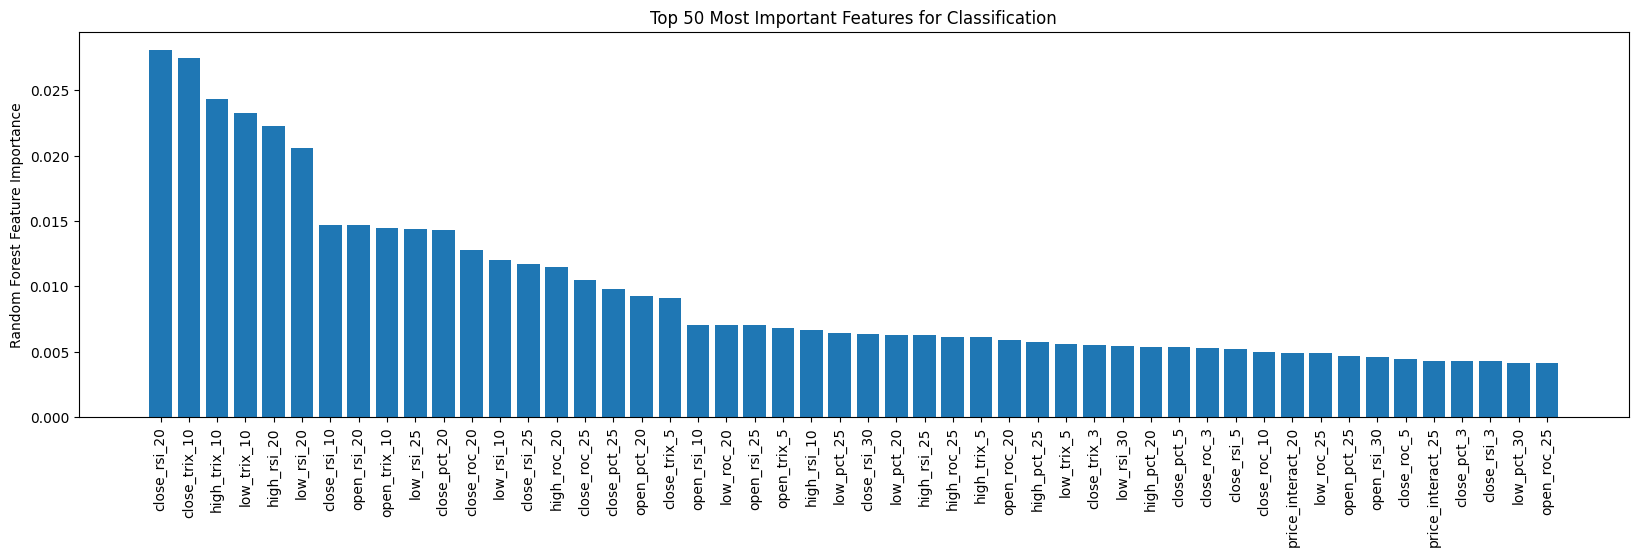

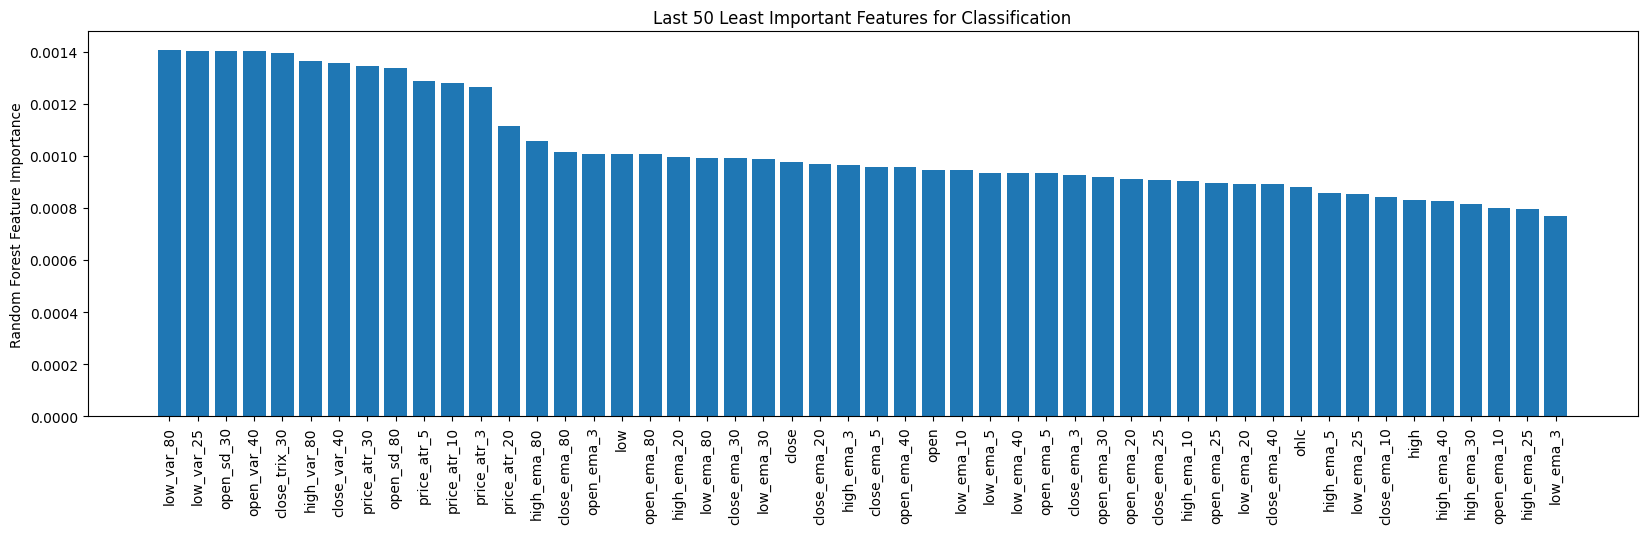

In [15]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]  # Reverse the sorting order

# Get top features
top_indices = sorted_idx[:50]
top_importances = importances[top_indices]
top_features_classification = X.columns[top_indices]

plt.figure(figsize=(20, 5))
plt.bar(top_features_classification, top_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Top 50 Most Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

# Get last 50 features
last_indices = sorted_idx[-50:]
last_importances = importances[last_indices]
last_features_classification = X.columns[last_indices]

plt.figure(figsize=(20, 5))
plt.bar(last_features_classification, last_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Last 50 Least Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()


In [ ]:
# print("top_50_features_classification =", top_features_classification)
# print("last_50_features_classification =",last_features_classification)

**Observation**:

**Top Features**:
The most significant features primarily revolve around various indicators with different periods:

1. **Relative Strength Index (RSI)**: Several periods of RSI for the close price, such as RSI 20, RSI 10, RSI 25, and RSI 30, have been highlighted as vital. RSI is a momentum oscillator that measures the speed and change of price movements.

2. **TRIX**: TRIX indicators for close, high, and low prices with periods like 10, 5, and 3 feature prominently. TRIX is a momentum oscillator that displays the percent rate of change of a triple exponentially smoothed moving average.

3. **Rate of Change (ROC)**: Various periods of ROC for close price like ROC 20 and ROC 25 are significant. ROC is a momentum oscillator that measures the percentage change between the current price and a past price.

4. **Percentage Change (PCT)**: The close price's percentage changes for periods like 20 and 25 are also key features.

5. **Other Interactions**: Features such as `price_interact_20` and `price_interact_25` hint at interactions between price and other technical indicators or periods.

**Least Important Features**:
Features that have shown to be less predictive are:

1. **Variance & Standard Deviation**: Features related to variance and standard deviation for various periods like `low_var_80`, `open_sd_30`, and `close_var_40` are among the less significant.

2. **Price Average True Range (ATR)**: Different periods of ATR like `price_atr_30` and `price_atr_5` are not highly ranked. ATR measures market volatility.

3. **Exponential Moving Averages (EMA)**: EMAs for several prices (close, open, low, high) across various periods (80, 20, 30, etc.) are also among the less significant features. EMA is a type of weighted moving average where more weight is given to the latest data.

Overall, while the most crucial features predominantly focus on momentum oscillators and their interactions across different periods, the less significant ones are spread across volatility measures, moving averages, and other indicators.

**For next steps:**

We select most importance features from top of the list to build Deep learning model
- Indicators: RSI, TRIX, ROC, PCT, price interaction
- Periods: 20, 10, 25, 5, 3


----

### Experiment 1: RNNs with LSTM simple features

Recurrent Neural Networks (RNNs) with Long Short-Term Memory (LSTM) units are a great choice for predicting time series data due to their ability to remember long-term dependencies. Here's a brief overview of the design, layers, and dimensions:

#### Model Design:

**1. Input Layer:**
- **Dimension**: [batch_size, time_steps, number_of_features]
  - **batch_size**: The number of samples in a batch.
  - **time_steps**: The number of time periods you're using as input. For instance, if you're using the last 60 periods of data to predict the next one, your time_steps would be 60.
  - **number_of_features**: The number of features in your dataset (e.g., close price, volume, etc.).

**2. LSTM Layer(s):**
LSTM layers are the heart of the model. You can stack multiple LSTM layers to make the model more complex.

- **Units**: Number of LSTM units or cells. This is a hyperparameter to tune, but common numbers are 50, 100, or 200.
- **Return sequences**: If stacking multiple LSTM layers, set this to `True` so that the next LSTM layer receives sequences and not just the last output.
- **Dropout**: LSTMs can be prone to overfitting, so you can introduce dropout between the LSTM layers. A common dropout rate is between 0.2 to 0.5.

**3. Dense Layer(s):**
After LSTM layers, you can have one or more densely connected layers to interpret the features extracted by the LSTM layers.

- **Units**: Typically, if you're predicting the next value in a sequence, this would be 1. If you're predicting multiple future values, adjust accordingly.
- **Activation function**: `linear` for regression tasks, `sigmoid` for binary classification, and `softmax` for multi-class classification.

**4. Output Layer:**
- **Units**: If you're predicting the trend (up, down, stationary), you might have 3 units (for 3 classes) and use `softmax` activation. For regression tasks predicting the next value, you'd have 1 unit with a `linear` activation.

**Summary of Model Architecture:**
```
Input -> [LSTM -> Dropout]* -> Dense -> Output
```

*(The `[LSTM -> Dropout]*` notation means you can have multiple repeating LSTM and Dropout layers stacked on each other)*

**Rebuild Features with target t+3**

We will use time series data with:
- **(t) time_steps**
- **(f) features**

input shape: (time_steps, features)

##### Simple features from % change

In [36]:
import numpy as np
import pandas as pd

def get_dl_features_v0(df, T=3):

    df = df.copy()

    # ++ Features ++
    inputs = ['open', 'high', 'low', 'close', 'volume']

    # log volume
    df.loc[:, 'volume'] = np.log(df['volume'])

    # range from 1 to T
    lags = [x for x in range(0, T)]

    # loop lags
    for lag in lags:
        # loop periods and inputs
        for input in inputs:
            if lag == 0:
                # % of change
                column_name = f'{input}_lag{lag}'
                df.insert(0, column_name, df[input].pct_change(periods=1))

            else:
                # use lagged price, sort from oldest to newest
                column_name = f'{input}_lag{lag}'
                df.insert(0, column_name, df[f'{input}_lag0'].shift(lag))

        df = df.copy()

    # drop unused columns
    drop_columns = ['open', 'high', 'low', 'close','volume']
    df.drop(columns=drop_columns, inplace=True)

    return df

# ===
T = 25 # number of periods to use as input features

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=3)
df = get_dl_features_v0(df, T=T)
df.dropna(inplace=True)

F = int((df.shape[1] -1) / T) # number of input features 
C = 5 # number of classes

# print(df.head(5))
# print(df.tail(5))

# Count target values
print("Count", df['target'].value_counts())

print("Data shape: ", df.shape ) 
print(f"Input shape: ({T}, {F})")
df.describe()


Count target
 0.0    8820
 1.0    3777
-1.0    3720
 2.0    3286
-2.0    3284
Name: count, dtype: int64
Data shape:  (22887, 126)
Input shape: (25, 5)


,volume_lag24,close_lag24,low_lag24,high_lag24,open_lag24,volume_lag23,close_lag23,low_lag23,high_lag23,open_lag23,...,close_lag1,low_lag1,high_lag1,open_lag1,volume_lag0,close_lag0,low_lag0,high_lag0,open_lag0,target
count,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,...,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000
mean,0.001828,0.000023,0.000026,0.000018,0.000024,0.001822,0.000023,0.000025,0.000018,0.000024,...,0.000023,0.000025,0.000018,0.000023,0.001831,0.000023,0.000025,0.000018,0.000023,0.002665
std,0.062902,0.007454,0.007722,0.006784,0.007558,0.062898,0.007454,0.007721,0.006784,0.007558,...,0.007453,0.007721,0.006783,0.007557,0.062926,0.007453,0.007721,0.006783,0.007557,1.214855
min,-0.760983,-0.105017,-0.130847,-0.087252,-0.090518,-0.760983,-0.105017,-0.130847,-0.087252,-0.090518,...,-0.105017,-0.130847,-0.087252,-0.090518,-0.760983,-0.105017,-0.130847,-0.087252,-0.090518,-2.000000
25%,-0.035440,-0.002713,-0.002374,-0.002512,-0.002718,-0.035440,-0.002713,-0.002374,-0.002512,-0.002718,...,-0.002710,-0.002371,-0.002506,-0.002714,-0.035440,-0.002710,-0.002371,-0.002506,-0.002714,-1.000000
50%,-0.004058,0.000026,0.000288,-0.000249,0.000024,-0.004066,0.000026,0.000288,-0.000249,0.000024,...,0.000026,0.000285,-0.000250,0.000024,-0.004058,0.000026,0.000285,-0.000250,0.000024,0.000000
75%,0.032366,0.002776,0.002790,0.002255,0.002774,0.032358,0.002775,0.002789,0.002255,0.002774,...,0.002774,0.002784,0.002255,0.002773,0.032350,0.002774,0.002784,0.002255,0.002773,1.000000
max,2.849711,0.123159,0.108805,0.121771,0.142847,2.849711,0.123159,0.108805,0.121771,0.142847,...,0.123159,0.108805,0.121771,0.142847,2.849711,0.123159,0.108805,0.121771,0.142847,2.000000


**Simple RNNs**

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)
# y = df['target']

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df['target'].values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# pre-processing steps
scaler = StandardScaler()

# Fit the scaler using the training data
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)

X_train_pre = X_train_pre.reshape(-1, T, F)
X_test_pre = X_test_pre.reshape(-1, T, F)

print("X_train shape", X_train.shape)
print("X_train_pre shape", X_train_pre.shape)
print("X_test shape", X_test.shape)
print("X_test_pre shape", X_test_pre.shape)
print("==============")
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)


X_train shape (16020, 125)
X_train_pre shape (16020, 25, 5)
X_test shape (6867, 125)
X_test_pre shape (6867, 25, 5)
y_train shape (16020, 5)
y_test shape (6867, 5)


In [38]:
input_shape = (T, F) # (time_steps, features)

# Create the LSTM model
model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(units=50))
model.add(Dropout(0.4))

# Dense layer
model.add(Dense(units=25))

# Output layer
# Classification with N classes, use N units and 'softmax' activation
model.add(Dense(units=C, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pre, y_train, epochs=50, batch_size=128, validation_data=(X_test_pre, y_test), verbose=0)




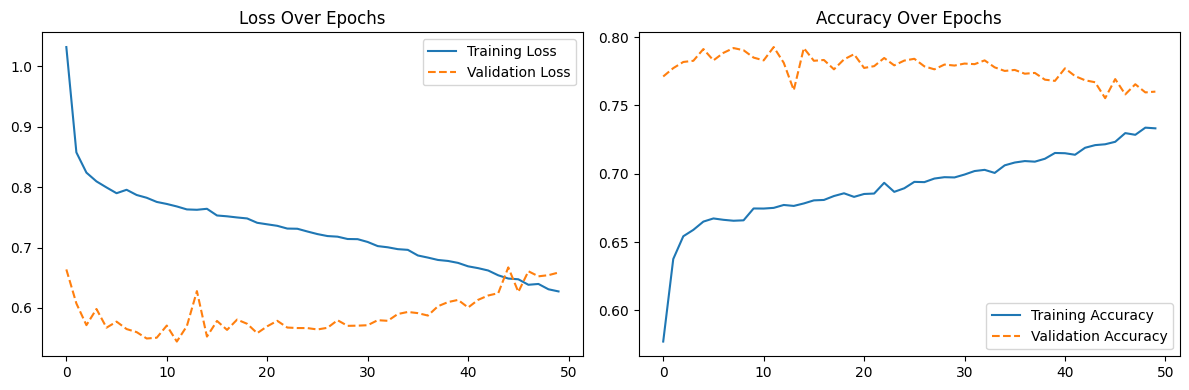

In [39]:
# plot loss and accuracy vs validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model

# Get predictions
y_pred = model.predict(X_test_pre)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Get classification report
report = classification_report(y_test_labels, y_pred_labels)
print("classification_report = \n", report)

# Get confusion matrix
matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("confusion_matrix = \n", matrix)


215/215 [==============================] - 1s 3ms/step
classification_report = 
               precision    recall  f1-score   support

           0       0.50      0.46      0.48       636
           1       0.72      0.71      0.72       841
           2       0.84      0.89      0.87      3885
           3       0.71      0.64      0.67       823
           4       0.56      0.50      0.53       682

    accuracy                           0.76      6867
   macro avg       0.67      0.64      0.65      6867
weighted avg       0.75      0.76      0.76      6867

confusion_matrix = 
 [[ 292  152  189    0    3]
 [ 128  596  117    0    0]
 [ 163   75 3468   79  100]
 [   1    0  135  526  161]
 [   2    2  199  141  338]]


Performance of Simple RNNs with simple features from % change is worst than ML Voting Classifier. In next experiment, we will try to use more features from indicators.

----

### Experiment 2: RNNs with LSTM and selected features from indicators